In [1]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
from dotenv import dotenv_values

from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string

In [2]:
config = dotenv_values()

# define variables for the login
pg_user = config['POSTGRES_USER']  # align the key label with your .env file !
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']


url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'


In [3]:
engine = create_engine(url, echo=False)
my_schema = 'capstone_barstov_industries'

with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))


In [4]:
with engine.begin() as conn: 
    result = conn.execute(text(f'''
                               SELECT * FROM product_analysis; 
                                '''))
    data = result.all()

### Let's create a dataframe out of that
product_analysis = pd.DataFrame(data) 
product_analysis.head(5)

,article_id,product_type_no,product_type_name,product_group_name,colour_group_code,colour_group_name,index_code,index_name,section_name,garment_group_no,unique_customers,total_sales,average_price,month,week,units_sold,abc_category,avg_customer_age,postal_code
0,572797001,253,Vest top,Garment Upper body,9,Black,A,Ladieswear,Womens Casual,1005,9623,1.401441,0.010523,2020-08-01,2020-08-17,49,A,39.823633,f8e422ead9eb7b22f861bdc7ab44586cb8103c275e2337...
1,898931001,253,Vest top,Garment Upper body,9,Black,A,Ladieswear,Womens Casual,1005,480,1.636340,0.011504,2020-08-01,2020-08-17,51,A,37.151210,80355192cecd5f9e9bc8994f4aded657eb0cc373e8e1d7...
2,884754001,274,Shorts,Garment Lower body,93,Dark Green,F,Menswear,Men Underwear,1002,187,0.389559,0.023839,2020-08-01,2020-08-10,16,A,35.058511,403b00eebb203284edddcee9da2c13d6a819c35f609c31...
3,893429001,67,Belt,Accessories,9,Black,C,Ladies Accessories,Womens Big accessories,1019,526,0.065203,0.008249,2020-08-01,2020-08-10,9,B,30.569316,4f88f48fd1345f6ae3a634caadee2d9355d50a34f3ec53...
4,856840001,265,Dress,Garment Full body,12,Light Beige,A,Ladieswear,Womens Everyday Collection,1005,1707,5.455941,0.016212,2020-08-01,2020-08-17,102,A,49.056150,65e83d1376cd2882461012272f95450b96795dfbc3243b...


In [34]:
product_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104510 entries, 0 to 104509
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   article_id          104510 non-null  int64  
 1   product_type_no     104510 non-null  int64  
 2   product_type_name   104510 non-null  object 
 3   product_group_name  104510 non-null  object 
 4   colour_group_code   104510 non-null  int64  
 5   colour_group_name   104510 non-null  object 
 6   index_code          104510 non-null  object 
 7   index_name          104510 non-null  object 
 8   section_name        104510 non-null  object 
 9   garment_group_no    104510 non-null  int64  
 10  unique_customers    104510 non-null  int64  
 11  total_sales         104510 non-null  float64
 12  average_price       104510 non-null  float64
 13  month               104510 non-null  object 
 14  week                104510 non-null  object 
 15  units_sold          104510 non-nul

In [5]:
# Aggregate data by product type and color group to summarize demand
product_data = product_analysis.groupby(['product_type_no', 'colour_group_code', 'garment_group_no']).agg({
    'units_sold': 'sum'  # Aggregated demand
}).reset_index()

In [6]:
from sklearn.preprocessing import StandardScaler

# Select features for scaling
features = product_data[['units_sold', 'product_type_no', 'colour_group_code', 'garment_group_no']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

In [7]:
import hdbscan

# Initialize HDBSCAN with chosen parameters
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10)
product_clusters = hdbscan_clusterer.fit_predict(scaled_data)

# Add cluster labels back to the data
product_data['cluster'] = product_clusters

In [8]:
import numpy as np

# Display cluster distribution
unique, counts = np.unique(product_clusters, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)


Cluster distribution: {np.int64(-1): np.int64(1626), np.int64(0): np.int64(17), np.int64(1): np.int64(64), np.int64(2): np.int64(76), np.int64(3): np.int64(12), np.int64(4): np.int64(10), np.int64(5): np.int64(10), np.int64(6): np.int64(14), np.int64(7): np.int64(61), np.int64(8): np.int64(17), np.int64(9): np.int64(12), np.int64(10): np.int64(10), np.int64(11): np.int64(33), np.int64(12): np.int64(31), np.int64(13): np.int64(18), np.int64(14): np.int64(10), np.int64(15): np.int64(15), np.int64(16): np.int64(10), np.int64(17): np.int64(53), np.int64(18): np.int64(20), np.int64(19): np.int64(15), np.int64(20): np.int64(49), np.int64(21): np.int64(11), np.int64(22): np.int64(35), np.int64(23): np.int64(65), np.int64(24): np.int64(19), np.int64(25): np.int64(29), np.int64(26): np.int64(63), np.int64(27): np.int64(26), np.int64(28): np.int64(51), np.int64(29): np.int64(28), np.int64(30): np.int64(54), np.int64(31): np.int64(80), np.int64(32): np.int64(35), np.int64(33): np.int64(148), np.i

In [9]:
# Summarize average demand and characteristics by cluster
cluster_summary = product_data.groupby('cluster').mean()
print(cluster_summary)

         product_type_no  colour_group_code  garment_group_no  units_sold
cluster                                                                  
-1            237.676507          37.457565       1010.762608  406.445264
 0            508.470588          50.294118       1019.000000   19.000000
 1            499.781250          10.312500       1019.046875   15.265625
 2             76.052632          12.131579       1001.000000    5.671053
 3             76.083333          11.000000       1003.000000    4.500000
...                  ...                ...               ...         ...
 143          262.241379           9.206897       1008.000000   13.137931
 144          263.757576          12.611111       1005.000000   36.883838
 145          262.742138          13.232704       1006.000000   10.452830
 146          265.000000          11.172414       1011.000000    7.344828
 147          261.708861          12.417722       1010.000000   22.620253

[149 rows x 4 columns]


In [10]:
# Aggregate data by cluster and month for ARIMA
cluster_time_data = product_analysis.groupby(['cluster', product_analysis['t_date'].dt.to_period('M')]).agg({
    'units_sold': 'sum'
}).reset_index()

# Rename columns for clarity
cluster_time_data.columns = ['cluster', 'month', 'units_sold']

# Convert period to datetime format for ARIMA compatibility
cluster_time_data['month'] = cluster_time_data['month'].dt.to_timestamp()


KeyError: 't_date'

In [12]:
# Create a dictionary for time series by cluster
cluster_series_dict = {cluster: data[['month', 'units_sold']].set_index('month') 
                       for cluster, data in cluster_time_data.groupby('cluster')}


NameError: name 'cluster_time_data' is not defined

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Example parameters for ARIMA (adjust as needed)
arima_order = (1, 1, 1)

# Dictionary to store ARIMA results for each cluster
arima_results = {}

# Loop through each cluster and fit ARIMA
for cluster, series in cluster_series_dict.items():
    # Fill missing months with 0, if any
    series = series.asfreq('M', fill_value=0)
    
    # Fit ARIMA model to each cluster’s time series
    try:
        model = ARIMA(series['units_sold'], order=arima_order)
        arima_fit = model.fit()
        
        # Save model summary or forecast to results dictionary
        arima_results[cluster] = arima_fit.summary()  # Or save arima_fit.forecast(steps=12) for predictions
        print(f"ARIMA model fit for Cluster {cluster}")
        
    except Exception as e:
        print(f"Could not fit ARIMA for Cluster {cluster}: {e}")


#### NEW CLUSTERS ####

In [13]:
# Aggregate data by product type, color, section, and month
product_demand_data = product_analysis.groupby([
    'product_type_no', 'product_type_name', 'product_group_name', 'colour_group_code',
    'index_code', 'section_name', 'month'
]).agg({
    'units_sold': 'sum'
}).reset_index()


In [14]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns to standardize (e.g., units_sold, colour_group_code)
numeric_features = ['units_sold', 'colour_group_code', 'product_type_no']
scaler = StandardScaler()
product_demand_data[numeric_features] = scaler.fit_transform(product_demand_data[numeric_features])


In [15]:
import hdbscan

# Define features for clustering
clustering_features = ['units_sold', 'colour_group_code', 'product_type_no']

# Run HDBSCAN on selected features
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=20)
product_demand_data['cluster'] = hdbscan_clusterer.fit_predict(product_demand_data[clustering_features])


In [16]:
# Summarize clusters to check their characteristics
cluster_summary = product_demand_data.groupby('cluster').agg({
    'product_type_name': 'nunique',
    'units_sold': 'mean',
    'colour_group_code': 'nunique'
}).sort_values('units_sold', ascending=False)
print(cluster_summary)


         product_type_name  units_sold  colour_group_code
cluster                                                  
104                      8    5.141385                  5
47                      10    2.945050                  3
546                      5    2.547786                  6
517                      4    2.251088                  4
48                       8    1.971533                  3
...                    ...         ...                ...
284                      1   -0.212358                  1
936                      1   -0.212358                  1
337                      4   -0.212358                  1
184                      2   -0.212358                  1
676                      1   -0.212358                  1

[998 rows x 3 columns]


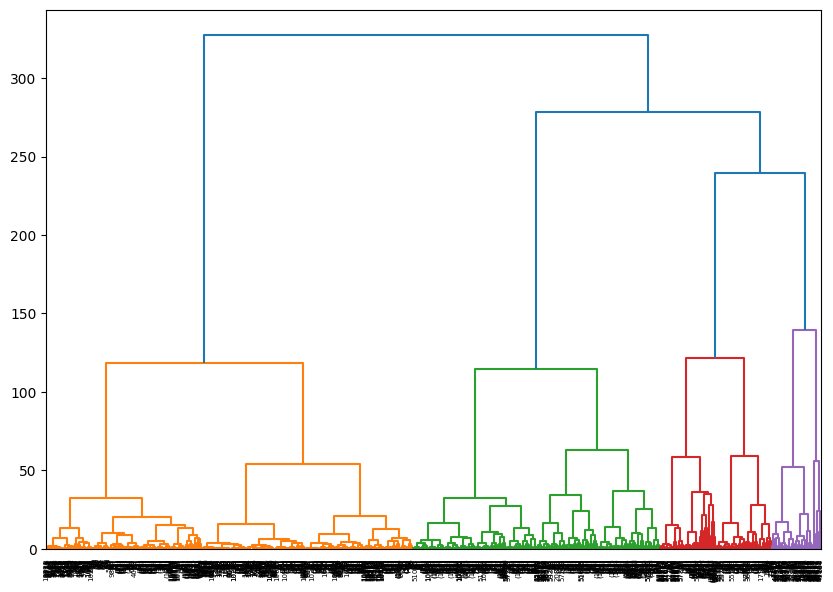

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
# Linkage for hierarchical clustering, e.g., on selected features
linked = linkage(product_demand_data[clustering_features], method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level', p=10)  # Adjust p for the level of detail
plt.show()


In [29]:
from scipy.cluster.hierarchy import fcluster

# Set a height level for cutting the dendrogram, e.g., 150
cutoff_height = 150
cluster_labels = fcluster(linked, cutoff_height, criterion='distance')

# Add the cluster labels to your DataFrame for analysis
product_demand_data['cluster'] = cluster_labels


In [30]:
print(product_demand_data)

       product_type_no product_type_name     product_group_name  \
0            -3.074878           Unknown                Unknown   
1            -3.074878           Unknown                Unknown   
2            -3.074878           Unknown                Unknown   
3            -3.074878           Unknown                Unknown   
4            -3.074878           Unknown                Unknown   
...                ...               ...                    ...   
57817         6.909611        Marker pen             Stationery   
57818         6.909611        Marker pen             Stationery   
57819         6.922714       Zipper head  Garment and Shoe care   
57820         6.922714       Zipper head  Garment and Shoe care   
57821         6.922714       Zipper head  Garment and Shoe care   

       colour_group_code index_code        section_name       month  \
0              -1.013967          B     Womens Lingerie  2020-08-01   
1              -1.013967          D        Ladies Den

In [31]:
# Summarize clusters by averaging relevant columns
cluster_summary = product_demand_data.groupby('cluster').agg({
    'product_type_no': 'mean',
    'colour_group_code': 'mean',
    'units_sold': ['mean', 'count']  # Count gives the size of each cluster
})

print(cluster_summary)


        product_type_no colour_group_code units_sold       
                   mean              mean       mean  count
cluster                                                    
1             -2.040706         -0.122680  -0.100608  10468
2              0.448890          0.991039  -0.072009  22094
3              0.454416         -0.818094   0.024509  25118
4              0.213607         -0.442990  14.285318    142


### ANOTHER APPROACH ###

In [35]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns to standardize (you can add or remove features as necessary)
numeric_features = ['units_sold', 'unique_customers', 'average_price']
scaler = StandardScaler()
product_analysis[numeric_features] = scaler.fit_transform(product_analysis[numeric_features])


In [36]:
import hdbscan

# Define the clustering features (add or remove features based on your analysis goals)
clustering_features = ['units_sold', 'unique_customers', 'average_price']
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10)

# Fit the clustering algorithm and add the cluster labels to the DataFrame
product_analysis['cluster'] = hdbscan_clusterer.fit_predict(product_analysis[clustering_features])


In [37]:
print("Unique clusters:", product_analysis['cluster'].unique())


Unique clusters: [  -1  238  398 ...  323 1257 1870]


In [38]:
# Summarize clusters using mode for categorical variables and mean for numerical ones
cluster_summary = product_analysis.groupby('cluster').agg({
    'product_type_no': lambda x: x.mode().iloc[0],  # Most frequent product type
    'product_type_name': lambda x: x.mode().iloc[0],  # Most frequent product type name
    'colour_group_code': lambda x: x.mode().iloc[0],  # Most frequent color group code
    'colour_group_name': lambda x: x.mode().iloc[0],  # Most frequent color group name
    'product_type_name': 'nunique',  # Number of unique product types in the cluster
    'units_sold': 'mean',  # Mean units sold as a demand indicator
    'unique_customers': 'mean',  # Mean unique customers
    'average_price': 'mean'  # Mean average price
}).reset_index()

print("Cluster Summary with Mode and Mean:")
print(cluster_summary)


Cluster Summary with Mode and Mean:
      cluster  product_type_no  product_type_name  colour_group_code  \
0          -1              265                124                  9   
1           0              272                  7                  9   
2           1              265                  8                  9   
3           2              272                  8                  9   
4           3              272                  9                  9   
...       ...              ...                ...                ...   
1929     1928              274                  7                 73   
1930     1929              252                 13                  9   
1931     1930               69                  9                 51   
1932     1931              252                 10                 73   
1933     1932              272                  6                 10   

     colour_group_name  units_sold  unique_customers  average_price  
0                Black    0.1

In [39]:
# Frequency distribution of product types by cluster
product_type_distribution = product_analysis.groupby(['cluster', 'product_type_no']).size().unstack(fill_value=0)
colour_group_distribution = product_analysis.groupby(['cluster', 'colour_group_code']).size().unstack(fill_value=0)

print("Product Type Distribution by Cluster:")
print(product_type_distribution.head())

print("Colour Group Distribution by Cluster:")
print(colour_group_distribution.head())


Product Type Distribution by Cluster:
product_type_no  -1     49    57    59    60    66    67    68    69    70   \
cluster                                                                       
-1                 71    15   383   808    13   708   248    84   233   587   
 0                  0     0     0     0     0     0     0     0     0     0   
 1                  0     0     0     0     0     0     0     0     0     0   
 2                  0     0     0     1     0     0     0     0     0     0   
 3                  0     0     1     0     0     0     0     0     0     0   

product_type_no  ...   512   514   515   521   523   525   529   532   761  \
cluster          ...                                                         
-1               ...    22     0     5     4     2     1     4     2     5   
 0               ...     0     0     0     0     0     0     0     0     0   
 1               ...     0     0     0     0     0     0     0     0     0   
 2               .

In [40]:
# Filter clusters with high units_sold and unique_customers
high_demand_clusters = cluster_summary[(cluster_summary['units_sold'] > 1) & 
                                       (cluster_summary['unique_customers'] > 1)]
print("High-Demand Clusters:")
print(high_demand_clusters)


High-Demand Clusters:
    cluster  product_type_no  product_type_name  colour_group_code  \
4         3              272                  9                  9   
6         5              272                  7                  9   
14       13              274                  9                  9   
16       15              255                 11                  9   
20       19              258                 13                  9   
21       20              265                  8                  9   
26       25               59                  9                 10   
28       27              253                  9                  9   
34       33              252                  9                  9   
35       34              265                  8                 10   
39       38              306                  9                  9   
42       41              258                  7                  9   
52       51              252                 13                  9  